In [ ]:
%pip install datasets -q
%pip install accelerate -U -q
%pip install transformers -q
%pip install scikit-learn==1.2.2 -q

In [1]:
import urllib
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from datasets import Dataset
import torch
from transformers import (
    BertModel,
    BertTokenizer,
)
import os
import matplotlib.pyplot as plt
import tqdm.notebook as tq
import pickle

/home/leonardo/Projects/NLP_ASSIGNMENT_2/Assignment2/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/leonardo/Projects/NLP_ASSIGNMENT_2/Assignment2/.venv/lib/python3.8/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/leonardo/Projects/NLP_ASSIGNMENT_2/Assignment2/.venv/lib/python3.8/site-packages/torch/cuda/__init__.py:740: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: %s" % device)

## TASK 1: Corpus


In [2]:
### Argument urls
argument_urls = {
    "train": "https://zenodo.org/records/8248658/files/arguments-training.tsv?download=1",
    "validation": "https://zenodo.org/records/8248658/files/arguments-validation.tsv?download=1",
    "test": "https://zenodo.org/records/8248658/files/arguments-test.tsv?download=1",
}

### Human values urls
level2_values_urls = {
    "train": "https://zenodo.org/records/8248658/files/labels-training.tsv?download=1",
    "validation": "https://zenodo.org/records/8248658/files/labels-validation.tsv?download=1",
    "test": "https://zenodo.org/records/8248658/files/labels-test.tsv?download=1",
}
### Check that the splits in the dict keys were not misspelled
for split in level2_values_urls.keys():
    assert split in argument_urls.keys(), "url dictionary keys misspelled"

In [3]:
### Create Data folder
data_folder = Path.cwd().joinpath("Data")
if not data_folder.exists():
    data_folder.mkdir(parents=True)

### Path for each file
argument_paths = {
    split: data_folder.joinpath(f"arguments_{split}.tsv")
    for split in argument_urls.keys()
}
level2_values_paths = {
    split: data_folder.joinpath(f"labels_{split}.tsv")
    for split in level2_values_urls.keys()
}

### Download each file if it's not already there
for file, path in argument_paths.items():
    if not path.exists():
        urllib.request.urlretrieve(argument_urls[file], filename=path)
for file, path in level2_values_paths.items():
    if not path.exists():
        urllib.request.urlretrieve(level2_values_urls[file], filename=path)

In [4]:
### Read arguments file (split = train/validation/test)
argument_dfs = {
    split: pd.read_csv(path, sep="\t") for split, path in argument_paths.items()
}

### Read human values file (split = train/validation/test)
level2_values_dfs = {
    values_split: pd.read_csv(path, sep="\t")
    for values_split, path in level2_values_paths.items()
}

In [5]:
### Merge arguments and (labels) level 2 values (split = train/validation/test)
args_level2vals_dfs = {
    split: pd.merge(argument, level2_values_dfs[split], on="Argument ID")
    for split, argument in argument_dfs.items()
}

In [ ]:
level2_values_dfs["train"].head(2)

In [ ]:
argument_dfs["train"].head(2)

In [ ]:
args_level2vals_dfs["train"].describe()

In [ ]:
args_level2vals_dfs["train"].head(2)

In [6]:
### Considering category ranges (0,3),(3,7),(7,13),(13,19)
### adding +4, considering the first 4 columns which are not categories
level3_categories_ranges = {
    "Openness_to_change": (4, 7),
    "Self_enhancement": (7, 11),
    "Conversation": (11, 17),
    "Self_transcendence": (17, 23),
}
columns_to_keep = ["Argument ID", "Conclusion", "Stance", "Premise"]
level_3_cat = list(level3_categories_ranges.keys())

In [7]:
### Creating final dataframes
train, validation, test = args_level2vals_dfs.keys()
assert train == "train" and validation == "validation" and test == "test"

### nm = not merged
train_df_nm = args_level2vals_dfs["train"]
validation_df_nm = args_level2vals_dfs["validation"]
test_df_nm = args_level2vals_dfs["test"]

### Creating final dataframes
train_df = pd.DataFrame()
validation_df = pd.DataFrame()
test_df = pd.DataFrame()

### Merge lvl2 to lvl 3 (any = OR)
for cat, (start, end) in level3_categories_ranges.items():
    train_df[cat] = train_df_nm.iloc[:, start:end].any(axis=1)
    validation_df[cat] = validation_df_nm.iloc[:, start:end].any(axis=1)
    test_df[cat] = test_df_nm.iloc[:, start:end].any(axis=1)

### Adding the columns to keep of the original dfs
train_df = pd.concat([train_df_nm[columns_to_keep], train_df], axis=1)
validation_df = pd.concat([validation_df_nm[columns_to_keep], validation_df], axis=1)
test_df = pd.concat([test_df_nm[columns_to_keep], test_df], axis=1)

### Define a mapping for "Stance" column
stance_mapping = {"in favor of": 1, "against": 0}

### Apply the mapping to convert strings to boolean values
train_df["Stance"] = train_df["Stance"].map(stance_mapping)
validation_df["Stance"] = validation_df["Stance"].map(stance_mapping)
test_df["Stance"] = test_df["Stance"].map(stance_mapping)

dfs = {"train": train_df, "validation": validation_df, "test": test_df}

In [ ]:
train_df["Conversation"].sum()

In [ ]:
train_df.head(2)

In [ ]:
train_df.describe()

# TASK 2: Model definition

## Baseline Model

In [8]:
def baseline_model(strategy, level_3_cat, train_df, columns_to_keep, seed=None):
    clf_list = [
        DummyClassifier(strategy=strategy, random_state=seed) for _ in level_3_cat
    ]
    [
        clf.fit(X=train_df[columns_to_keep[1:]], y=train_df[cat])
        for clf, cat in zip(clf_list, level_3_cat)
    ]
    return clf_list

## Bert - base Classifier

In [ ]:
### Convert dataframes into datasets
datasets = {split: Dataset.from_pandas(df) for split, df in dfs.items()}

In [ ]:
def compute_class_weights(df, cat_labels):
    labels_array = df[cat_labels].to_numpy()
    n_ones = np.sum(labels_array, axis=0, dtype=np.single)
    weights = np.empty_like(n_ones)
    n_zeroes = np.array([labels_array.shape[0] - o for o in n_ones])

    for class_num, (ones, zeroes) in enumerate(zip(n_ones, n_zeroes)):
        weights[class_num] = zeroes / (ones + 1e-4)

    print(f"weigts = {weights}")
    return torch.as_tensor(weights, dtype=torch.float).to(device)


def compute_class_weights_root(df, cat_labels):
    labels_array = df[cat_labels].to_numpy()
    n_ones = np.sum(labels_array, axis=0, dtype=np.single)
    weights = np.empty_like(n_ones)
    n_zeroes = np.array([labels_array.shape[0] - o for o in n_ones])

    for class_num, ones in enumerate(n_ones):
        weights[class_num] = np.sqrt(labels_array.shape[0] / (ones + 1e-4))

    print(f"weigts = {weights}")
    return torch.as_tensor(weights, dtype=torch.float).to(device)


def loss_fn(outputs, targets, pos_weight=None):
    return torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)(outputs, targets)

In [9]:
def add_labels(ds_row, labels):
    labels_batch = {k: ds_row[k] for k in ds_row.keys() if k in labels}
    labels_matrix = np.zeros((len(ds_row["Conclusion"]), len(labels)))
    for i, label in enumerate(labels):
        labels_matrix[:, i] = labels_batch[label]
    return labels_matrix.tolist()

### Bert-base Model

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self, stance=False):
        super().__init__()
        self.bert_model = BertModel.from_pretrained(
            "bert-base-uncased", return_dict=True
        )
        self.dropout = torch.nn.Dropout(0.3)
        if not stance:
            self.linear = torch.nn.Linear(768, len(level_3_cat))
        else:
            ### 769! there is "stance" as another input
            self.linear = torch.nn.Linear(769, len(level_3_cat))

    def forward(self, input_ids, token_type_ids, attn_mask, stance=None):
        output = self.bert_model(
            input_ids, attention_mask=attn_mask, token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)

        if stance is None:
            output_linear = self.linear(output_dropout)
        else:
            ### concatenate stance
            stance = stance.view(stance.shape[0], -1)
            output_stack = torch.cat((output_dropout, stance), dim=1)
            output_linear = self.linear(output_stack)
        return output_linear

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
### Encoding
def tokenize(ds_row, tokenizer=tokenizer, premise=False, stance=False):
    ### Tokenize text columns
    print(f"PREMISE = {premise}  STANCE = {stance}")
    if not premise:
        text_tokens = tokenizer(
            ds_row["Conclusion"],
            truncation=True,
            padding="max_length",
            max_length=tokenizer.model_max_length // 2,
            return_tensors="pt",
        )
    else:
        text_tokens = tokenizer(
            ds_row["Conclusion"],
            ds_row["Premise"],
            truncation=True,
            padding="max_length",
            max_length=tokenizer.model_max_length // 2,
            return_tensors="pt",
        )

    ### Combine text tokens with non-text features
    encoded_ds_row = {
        "input_ids": text_tokens["input_ids"],
        "token_type_ids": text_tokens["token_type_ids"],
        "attention_mask": text_tokens["attention_mask"],
    }
    if stance:
        encoded_ds_row.update(
            {
                "Stance": torch.tensor(
                    ds_row["Stance"], dtype=torch.float
                ),  ### Assuming 'Stance' is represented as 0 or 1
            }
        )

    encoded_ds_row["labels"] = add_labels(ds_row, level_3_cat)

    return encoded_ds_row

In [ ]:
### Training of the model
def train_model(train_dl, model, optimizer, class_weights, use_stance=False):
    losses = []
    correct_predictions = 0
    num_samples = 0

    ### activate dropout, batch norm
    model.train()

    ### initialize progress bar
    batches = tq.tqdm(
        enumerate(train_dl), total=len(train_dl), leave=True, colour="steelblue"
    )

    for batch_idx, data in batches:
        ids = data["input_ids"].to(device, dtype=torch.long)
        mask = data["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
        labels = data["labels"].to(device, dtype=torch.float)
        if use_stance:
            stance = data["Stance"].to(device, dtype=torch.float)
            outputs = model(ids, token_type_ids, mask, stance)  ### Forward
        else:
            outputs = model(ids, token_type_ids, mask)  ### Forward

        loss = loss_fn(outputs, labels, class_weights)
        losses.append(loss.cpu().detach().numpy())

        ### apply thresh 0.5
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        labels = labels.cpu().detach().numpy()
        correct_predictions += np.sum(outputs == labels)
        num_samples += labels.size

        ### Backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        ### Grad descent step
        optimizer.step()

        ### Update progress bar
        batches.set_description(f"")
        batches.set_postfix(batch_loss=loss)

    accuracy = float(correct_predictions) / num_samples
    return model, accuracy, losses

# Task 3: Metrics

### Baseline Metric

In [10]:
def f1_baseline(prediction, labels, data):
    ### Evaluate F1 overall
    f1_overall = f1_score(
        y_true=data[labels], y_pred=prediction, average="macro", zero_division=np.nan
    )

    ### Evaluate F1 per category
    f1_per_cat = [
        f1_score(y_true=data[cat], y_pred=prediction[:, i])
        for i, cat in enumerate(labels)
    ]

    return f1_overall, f1_per_cat

### Bert base model metric

In [ ]:
def eval_model(validation_dl, model, class_weights, use_stance=False):
    losses = []
    correct_predictions = 0
    num_samples = 0
    num_categories = next(iter(validation_dl))["labels"].shape[1]

    ### accumulate data over each batch to compute the f1
    true_positives = np.array([0 for _ in range(num_categories)])
    false_positives = np.array([0 for _ in range(num_categories)])
    false_negatives = np.array([0 for _ in range(num_categories)])

    ### turn off dropout, fix batch norm
    model.eval()

    ### show progress bar
    batches = tq.tqdm(
        enumerate(validation_dl),
        total=len(validation_dl),
        leave=True,
        colour="steelblue",
    )
    # batches = enumerate(validation_dl)
    with torch.no_grad():
        for batch_idx, data in batches:
            ids = data["input_ids"].to(device, dtype=torch.long)
            mask = data["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
            labels = data["labels"].to(device, dtype=torch.float)
            if use_stance:
                stance = data["Stance"].to(device, dtype=torch.float)
                outputs = model(ids, token_type_ids, mask, stance)  ### Forward
            else:
                outputs = model(ids, token_type_ids, mask)

            loss = loss_fn(outputs, labels, class_weights)
            losses.append(loss.cpu().detach().numpy())

            ### validation accuracy
            ### training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            labels = labels.cpu().detach().numpy()
            correct_predictions += np.sum(outputs == labels)
            num_samples += labels.size

            ### TP: predicttion == 1, true label == 1
            true_positives += np.array(
                [
                    np.sum(np.logical_and(outputs[:, i] == 1, labels[:, i] == 1))
                    for i in range(num_categories)
                ]
            )

            ### FP: prediction == 1, true label == 0
            false_positives += np.array(
                [
                    np.sum(np.logical_and(outputs[:, i] == 1, labels[:, i] == 0))
                    for i in range(num_categories)
                ]
            )

            ### FN: prediction == 0, true label == 1
            false_negatives += np.array(
                [
                    np.sum(np.logical_and(outputs[:, i] == 0, labels[:, i] == 1))
                    for i in range(num_categories)
                ]
            )

        accuracy = float(correct_predictions) / num_samples
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        f1_per_cat = 2 * (precision * recall) / (precision + recall)
        f1_overall = np.mean(f1_per_cat)
    return accuracy, losses, f1_overall, f1_per_cat

# TASK 4 - Training and Evaluation

## Baseline

In [11]:
### Random uniform classifier

seeds = [333, 666, 999]
history_list_uniform = []
for seed in seeds:
    model_uniform = baseline_model(
        "uniform", level_3_cat, train_df, columns_to_keep, seed
    )

    prediction_uniform = np.array(
        [clf.predict(X=validation_df[columns_to_keep[1:]]) for clf in model_uniform]
    ).T

    f1_overall, f1_percat = f1_baseline(
        prediction_uniform, labels=level_3_cat, data=validation_df
    )

    history_list_uniform.append([f1_overall, f1_percat])

In [12]:
print("Random uniform classifier:")
for h, s in zip(history_list_uniform, seeds):
    print(f"SEED = {s}")
    print(f"f1_overall = {h[0]}  f1_per_cat = {h[1]}")

Random uniform classifier:
SEED = 333
f1_overall = 0.5124357057924442  f1_per_cat = [0.4307692307692307, 0.44218838127467563, 0.5909863945578232, 0.5857988165680473]
SEED = 666
f1_overall = 0.5211104928753427  f1_per_cat = [0.42398022249690986, 0.4597961494903737, 0.5978678038379531, 0.6027977956761339]
SEED = 999
f1_overall = 0.5228458181625661  f1_per_cat = [0.427255985267035, 0.45807540799099605, 0.5959252971137522, 0.610126582278481]


In [13]:
### Majority classifier

prediction_majority = baseline_model(
    "most_frequent", level_3_cat, train_df, columns_to_keep
)

prediction_majority = np.array(
    [clf.predict(X=validation_df[columns_to_keep[1:]]) for clf in model_uniform]
).T

f1_overall, f1_percat = f1_baseline(
    prediction_majority, labels=level_3_cat, data=validation_df
)

history_majority = (f1_overall, f1_percat)

In [14]:
print("Majority classifier:")
print(f"SEED = {s}")
print(f"f1_overall = {history_majority[0]}  f1_per_cat = {history_majority[1]}")

Majority classifier:
SEED = 999
f1_overall = 0.5228458181625661  f1_per_cat = [0.427255985267035, 0.45807540799099605, 0.5959252971137522, 0.610126582278481]


## Bert-base models

In [ ]:
def create_data_loaders(tokenized_datasets, batch_size):
    train_dl = torch.utils.data.DataLoader(
        tokenized_datasets["train"],
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
    )

    validation_dl = torch.utils.data.DataLoader(
        tokenized_datasets["validation"],
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
    )

    test_dl = torch.utils.data.DataLoader(
        tokenized_datasets["test"],
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
    )
    return train_dl, validation_dl, test_dl

In [ ]:
def setup(
    datasets,
    learning_rate,
    batch_size=32,
    weight_decay=0.01,
    premise=False,
    stance=False,
    ### from here on there is no need to specify the arguments
    tokenization_function=tokenize,
    tokenizer=tokenizer,
    model_class=BERTClass,
):
    ### tokenize each ds in the datasets dictionary
    ### mapping the tokenization function on each dataset
    tokenized_datasets = {
        split: ds.map(
            function=tokenization_function,
            fn_kwargs={"tokenizer": tokenizer, "premise": premise, "stance": stance},
            batched=True,
            remove_columns=[
                "Argument ID",
                "Conclusion",
                "Stance",
                "Premise",
                "Openness_to_change",
                "Self_enhancement",
                "Conversation",
                "Self_transcendence",
            ],
        )
        for split, ds in datasets.items()
    }

    for ds in tokenized_datasets.values():
        ds.set_format(type="torch")

    train_dl, validation_dl, test_dl = create_data_loaders(
        tokenized_datasets, batch_size
    )

    ### define the model
    model = model_class(stance=stance)

    model.to(device)

    ### define the optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay
    )

    return (train_dl, validation_dl, test_dl), model, optimizer

In [ ]:
def train_eval(
    dls,
    model,
    optimizer,
    class_weights,
    n_epochs=1,
    save_name="0",
    use_stance=False,
    ### from here on there is no need to specify the arguments
    train_model_f=train_model,
    eval_model_f=eval_model,
):
    model_folder = Path.cwd().joinpath("models")
    if not model_folder.exists():
        model_folder.mkdir(parents=True)

    history = {}
    best_f1 = 0
    train_dl, validation_dl, test_dl = dls

    for epoch in range(1, n_epochs + 1):
        print(f"Epoch {epoch}/{n_epochs}")
        model, train_acc, train_losses = train_model_f(
            train_dl, model, optimizer, class_weights, use_stance
        )
        val_acc, val_losses, f1_overall, f1_per_cat = eval_model_f(
            validation_dl, model, class_weights, use_stance
        )

        print(
            f"train_loss={np.mean(train_losses):.4f}, val_loss={np.mean(val_losses):.4f}, ",
            f"train_acc={train_acc:.4f}, val_acc={val_acc:.4f}, ",
            f"val_f1_overall={f1_overall:.4f}, " f"val_f1_per_cat={f1_per_cat}",
        )

        history.update({"train_acc": train_acc})
        history.update({"train_losses": train_losses})
        history.update({"val_acc": val_acc})
        history.update({"val_losses": val_losses})
        history.update({"f1_overall": f1_overall})
        history.update({"f1_per_cat": f1_per_cat})

        ### save the best model
        if f1_overall > best_f1:
            torch.save(
                model.state_dict(),
                Path.joinpath(model_folder, f"model_{save_name}.bin"),
            )
            best_f1 = f1_overall

    return (history["f1_overall"], history["f1_per_cat"], history["train_losses"])

In [ ]:
### Generic Parameters
BATCH_SIZE = 32
N_EPOCHS = 1
LEARNING_RATE_3 = 3e-5
LEARNING_RATE_2 = 2e-5
WEIGHT_DECAY = 0.01

seeds = [333, 666, 999]
# seeds = [333, 666]
# class_weights = compute_class_weights(train_df, level_3_cat)
class_weights = compute_class_weights_root(train_df, level_3_cat)

plot_loss = True

### Bert Conclusion-Only  1 epoch



In [ ]:
LEARNING_RATE_Co = LEARNING_RATE_3

### loop over seeds:
history_list_c_lr3 = []
for seed_idx, seed in enumerate(seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)
    dls, model_c, optimizer_c = setup(
        datasets=datasets,
        learning_rate=LEARNING_RATE_Co,
        weight_decay=WEIGHT_DECAY,
        premise=False,
        stance=False,
    )

    history = train_eval(
        dls=dls,
        model=model_c,
        optimizer=optimizer_c,
        class_weights=class_weights,
        n_epochs=N_EPOCHS,
        save_name=f"conclusion_{seed_idx}",
        use_stance=False,
    )
    history_list_c_lr3.append(history)

In [ ]:
if plot_loss:
    plt.plot(history_list_c_lr3[0][2])

In [ ]:
LEARNING_RATE_Co = LEARNING_RATE_2

### loop over seeds:
history_list_c_lr2 = []
for seed_idx, seed in enumerate(seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)
    dls, model_c, optimizer_c = setup(
        datasets=datasets,
        learning_rate=LEARNING_RATE_Co,
        weight_decay=WEIGHT_DECAY,
        premise=False,
        stance=False,
    )

    history = train_eval(
        dls=dls,
        model=model_c,
        optimizer=optimizer_c,
        class_weights=class_weights,
        n_epochs=N_EPOCHS,
        save_name=f"conclusion_{seed_idx}",
        use_stance=False,
    )
    history_list_c_lr2.append(history)

In [ ]:
if plot_loss:
    plt.plot(history_list_c_lr2[0][2])

### Bert with Conclusion and Premise 1 epoch

In [ ]:
LEARNING_RATE_CP = LEARNING_RATE_3

### loop over seeds:
history_list_cp_lr3 = []
for seed_idx, seed in enumerate(seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)
    dls, model_cp, optimizer_cp = setup(
        datasets=datasets,
        learning_rate=LEARNING_RATE_CP,
        weight_decay=WEIGHT_DECAY,
        premise=True,
        stance=False,
    )

    history = train_eval(
        dls=dls,
        model=model_cp,
        optimizer=optimizer_cp,
        class_weights=class_weights,
        n_epochs=N_EPOCHS,
        save_name=f"conclusion_premise_{seed_idx}",
        use_stance=False,
    )
    history_list_cp_lr3.append(history)

In [ ]:
if plot_loss:
    plt.plot(history_list_cp_lr3[0][2])

In [ ]:
LEARNING_RATE_CP = LEARNING_RATE_2

### loop over seeds:
history_list_cp_lr2 = []
for seed_idx, seed in enumerate(seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)
    dls, model_cp, optimizer_cp = setup(
        datasets=datasets,
        learning_rate=LEARNING_RATE_CP,
        weight_decay=WEIGHT_DECAY,
        premise=True,
        stance=False,
    )

    history = train_eval(
        dls=dls,
        model=model_cp,
        optimizer=optimizer_cp,
        class_weights=class_weights,
        n_epochs=N_EPOCHS,
        save_name=f"conclusion_premise_{seed_idx}",
        use_stance=False,
    )
    history_list_cp_lr2.append(history)

In [ ]:
if plot_loss:
    plt.plot(history_list_cp_lr2[0][2])

### Bert with Conclusion Premise and Stance 1 epoch:

In [ ]:
LEARNING_RATE_CPS = LEARNING_RATE_3

### loop over seeds:
history_list_cps_lr3 = []
for seed_idx, seed in enumerate(seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)
    dls, model_cps, optimizer_cps = setup(
        datasets=datasets,
        learning_rate=LEARNING_RATE_CPS,
        weight_decay=WEIGHT_DECAY,
        premise=True,
        stance=True,
    )

    history = train_eval(
        dls=dls,
        model=model_cps,
        optimizer=optimizer_cps,
        class_weights=class_weights,
        n_epochs=N_EPOCHS,
        save_name=f"conclusion_premise_stance{seed_idx}",
        use_stance=True,
    )
    history_list_cps_lr3.append(history)

In [ ]:
if plot_loss:
    plt.plot(history_list_cps_lr3[0][2])

In [ ]:
LEARNING_RATE_CPS = LEARNING_RATE_2

### loop over seeds:
history_list_cps_lr2 = []
for seed_idx, seed in enumerate(seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)
    dls, model_cps, optimizer_cps = setup(
        datasets=datasets,
        learning_rate=LEARNING_RATE_CPS,
        weight_decay=WEIGHT_DECAY,
        premise=True,
        stance=True,
    )

    history = train_eval(
        dls=dls,
        model=model_cps,
        optimizer=optimizer_cps,
        class_weights=class_weights,
        n_epochs=N_EPOCHS,
        save_name=f"conclusion_premise_stance{seed_idx}",
        use_stance=True,
    )
    history_list_cps_lr2.append(history)

In [ ]:
if plot_loss:
    plt.plot(history_list_cps_lr2[0][2])

In [ ]:
for hl, name in zip(
    (
        history_list_c_lr3,
        history_list_c_lr2,
        history_list_cp_lr3,
        history_list_cp_lr2,
        history_list_cps_lr3,
        history_list_cps_lr2,
    ),
    ("C_lr3", "C_lr2", "CP_lr3", "CP_lr2", "CPS_lr3", "CPS_lr2"),
):
    print(name)
    for h, s in zip(hl, seeds):
        print(f"SEED = {s}")
        print(f"F1 overall = {h[0]:.4f}")
        print(f"F1 per cat = {[ f'{i:.4f}' for i in h[1] ]}\n")

### Bert Conclusion-Only  2 epochs



In [ ]:
### loop over seeds:
history_list_c_2e = []
for seed_idx, seed in enumerate(seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)
    dls, model_c, optimizer_c = setup(
        datasets=datasets,
        learning_rate=LEARNING_RATE_Co / 2,
        weight_decay=WEIGHT_DECAY,
        premise=False,
        stance=False,
    )

    history = train_eval(
        dls=dls,
        model=model_c,
        optimizer=optimizer_c,
        class_weights=class_weights,
        n_epochs=N_EPOCHS * 2,
        save_name=f"conclusion_{seed_idx}",
        use_stance=False,
    )
    history_list_c_2e.append(history)
plt.plot(history_list_c_2e[0][2])

### Bert with Conclusion and Premise 2 epoch

In [ ]:
### loop over seeds:
history_list_cp_2e = []
for seed_idx, seed in enumerate(seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)
    dls, model_cp, optimizer_cp = setup(
        datasets=datasets,
        learning_rate=LEARNING_RATE_CP / 2,
        weight_decay=WEIGHT_DECAY,
        premise=True,
        stance=False,
    )

    history = train_eval(
        dls=dls,
        model=model_cp,
        optimizer=optimizer_cp,
        class_weights=class_weights,
        n_epochs=N_EPOCHS * 2,
        save_name=f"conclusion_premise_{seed_idx}",
        use_stance=False,
    )
    history_list_cp_2e.append(history)
plt.plot(history_list_cp_2e[0][2])

### Bert with Conclusion Premise and Stance 1 epoch:

In [ ]:
### loop over seeds:
history_list_cps_2e = []
for seed_idx, seed in enumerate(seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)
    dls, model_cps, optimizer_cps = setup(
        datasets=datasets,
        learning_rate=LEARNING_RATE_CPS / 2,
        weight_decay=WEIGHT_DECAY,
        premise=True,
        stance=True,
    )

    history = train_eval(
        dls=dls,
        model=model_cps,
        optimizer=optimizer_cps,
        class_weights=class_weights,
        n_epochs=N_EPOCHS * 2,
        save_name=f"conclusion_premise_stance{seed_idx}",
        use_stance=True,
    )
    history_list_cps_2e.append(history)
plt.plot(history_list_cps_2e[0][2])

In [ ]:
for hl, name in zip(
    (
        history_list_c_2e,
        history_list_cp_2e,
        history_list_cps_2e,
    ),
    ("C_2e", "CP_2e", "CPS_2e"),
):
    print(name)
    for h, s in zip(hl, seeds):
        print(f"SEED = {s}")
        print(f"F1 overall = {h[0]:.4f}")
        print(f"F1 per cat = {[ f'{i:.4f}' for i in h[1] ]}\n")

# Task 5: Error Analysis

In [15]:
def avg_hist(hists):
    overall = np.average([hist[0] for hist in hists])
    per_cat = [np.average([hist[1][i] for hist in hists]) for i in range(4)]
    return [overall] + per_cat


def std_hist(hists):
    overall = np.std([hist[0] for hist in hists])
    per_cat = [np.std([hist[1][i] for hist in hists]) for i in range(4)]
    return [overall] + per_cat

In [16]:
#####################################

### TODO remove: FAKE DATA
fake_hist = [0.6, [0.5, 0.5, 0.7, 0.7], "fake loss"]

history_list_c_lr3 = [fake_hist, fake_hist, fake_hist]
history_list_cp_lr3 = [fake_hist, fake_hist, fake_hist]
history_list_cps_lr3 = [fake_hist, fake_hist, fake_hist]

history_list_c_lr2 = [fake_hist, fake_hist, fake_hist]
history_list_cp_lr2 = [fake_hist, fake_hist, fake_hist]
history_list_cps_lr2 = [fake_hist, fake_hist, fake_hist]

history_list_c_2e = [fake_hist, fake_hist, fake_hist]
history_list_cp_2e = [fake_hist, fake_hist, fake_hist]
history_list_cps_2e = [fake_hist, fake_hist, fake_hist]

#####################################

In [31]:
### class frequencies of the train set:
labels_array = train_df[level_3_cat].to_numpy()
class_frequencies = (
    np.sum(labels_array, axis=0, dtype=np.single) / labels_array.shape[0]
)
class_frequencies = np.concatenate([np.zeros(1), class_frequencies], axis=None)

### Compute avg, std over the random seeds
avg_f1_c_lr3 = avg_hist(history_list_c_lr3)
avg_f1_cp_lr3 = avg_hist(history_list_cp_lr3)
avg_f1_cps_lr3 = avg_hist(history_list_cps_lr3)

avg_f1_c_lr2 = avg_hist(history_list_c_lr2)
avg_f1_cp_lr2 = avg_hist(history_list_cp_lr2)
avg_f1_cps_lr2 = avg_hist(history_list_cps_lr2)

avg_f1_uniform = avg_hist(history_list_uniform)
avg_f1_majority = [history_majority[0]] + history_majority[1]

avg_f1_c_2e = avg_hist(history_list_c_2e)
avg_f1_cp_2e = avg_hist(history_list_cp_2e)
avg_f1_cps_2e = avg_hist(history_list_cps_2e)

### TODO use this
# std_f1_c_lr3 = std_hist(history_list_c_lr3)
# std_f1_cp_lr3 = std_hist(history_list_cp_lr3)
# std_f1_cps_lr3 = std_hist(history_list_cps_lr3)

# std_f1_c_lr2 = std_hist(history_list_c_lr2)
# std_f1_cp_lr2 = std_hist(history_list_cp_lr2)
# std_f1_cps_lr2 = std_hist(history_list_cps_lr2)

# std_f1_c_2e = std_hist(history_list_c_2e)
# std_f1_cp_2e = std_hist(history_list_cp_2e)
# std_f1_cps_2e = std_hist(history_list_cps_2e)

#####################
### TODO REMOVE FAKE DATA
std_f1_c_lr3 = [i for i in range(5)]
std_f1_cp_lr3 = [i for i in range(5, 10)]
std_f1_cps_lr3 = [i for i in range(10, 15)]

std_f1_c_lr2 = [i + 1 for i in range(5)]
std_f1_cp_lr2 = [i + 1 for i in range(5, 10)]
std_f1_cps_lr2 = [i + 1 for i in range(10, 15)]

std_f1_c_2e = [i + 1 for i in range(5)]
std_f1_cp_2e = [i + 1 for i in range(5, 10)]
std_f1_cps_2e = [i + 1 for i in range(10, 15)]

# f1_majority = range(5)
# f1_uniform = range(1, 6)
##############################

In [18]:
title_font = {
    "size": 16,
    "weight": "bold",
}
axis_font = {
    "size": 11,
}
legend_title_font = {"weight": "bold"}

### STD Versione lunga con 1 e 2 epoch

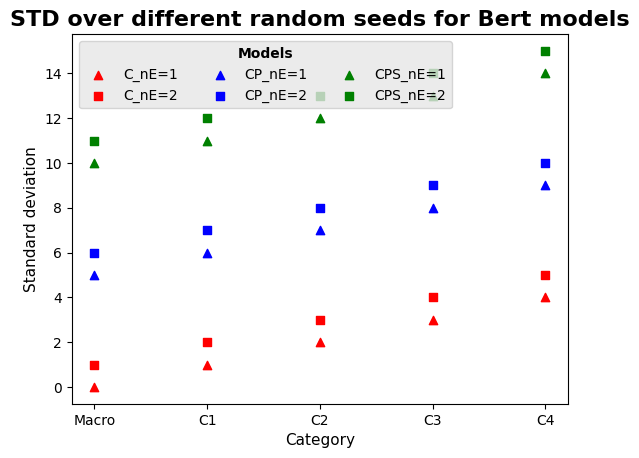

In [19]:
### Plot: variance over random seeds for Bert Models
# 1 grafico per lr (eventualmente mergiare 2 grafici)
# 5 colonne (macro + per cat)
# punti = std dev (C, CP, CPS)

std_devs = (
    std_f1_c_lr3,
    std_f1_c_2e,
    std_f1_cp_lr3,
    std_f1_cp_2e,
    std_f1_cps_lr3,
    std_f1_cps_2e,
)
color_list = ["red", "red", "blue", "blue", "green", "green"]
marker_list = ["^", "s", "^", "s", "^", "s"]
label_list = [
    "C_nE=1",
    "C_nE=2",
    "CP_nE=1",
    "CP_nE=2",
    "CPS_nE=1",
    "CPS_nE=2",
]

x_labels = ["Macro", "C1", "C2", "C3", "C4"]
plt.title("STD over different random seeds for Bert models", fontdict=title_font)
plt.xlabel("Category", fontdict=axis_font)
plt.ylabel("Standard deviation", fontdict=axis_font)
plt.xticks(ticks=range(len(std_devs[0])), labels=x_labels)
# plt.yscale("log")

for s, color, label, marker in zip(std_devs, color_list, label_list, marker_list):
    plt.scatter(x=range(len(s)), y=s, c=color, label=label, marker=marker)
plt.legend(
    title="Models",
    facecolor=(0.9, 0.9, 0.9),
    title_fontproperties=legend_title_font,
    ncols=3,
)

### STD versione lunga (con 2 learning rate)

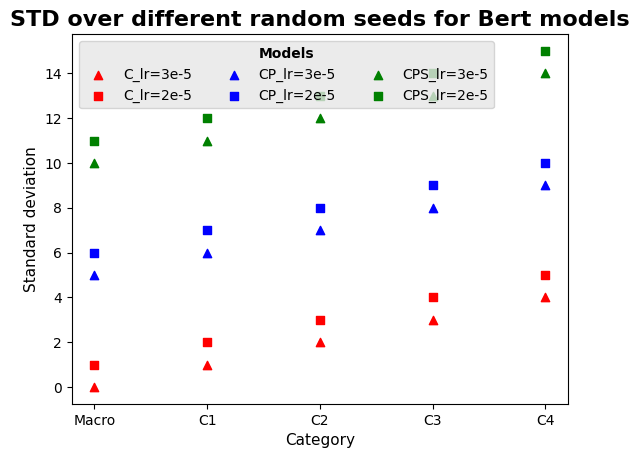

In [20]:
### Plot: variance over random seeds for Bert Models
# 1 grafico per lr (eventualmente mergiare 2 grafici)
# 5 colonne (macro + per cat)
# punti = std dev (C, CP, CPS)

std_devs = (
    std_f1_c_lr3,
    std_f1_c_lr2,
    std_f1_cp_lr3,
    std_f1_cp_lr2,
    std_f1_cps_lr3,
    std_f1_cps_lr2,
)
color_list = ["red", "red", "blue", "blue", "green", "green"]
marker_list = ["^", "s", "^", "s", "^", "s"]
label_list = [
    "C_lr=3e-5",
    "C_lr=2e-5",
    "CP_lr=3e-5",
    "CP_lr=2e-5",
    "CPS_lr=3e-5",
    "CPS_lr=2e-5",
]

x_labels = ["Macro", "C1", "C2", "C3", "C4"]
plt.title("STD over different random seeds for Bert models", fontdict=title_font)
plt.xlabel("Category", fontdict=axis_font)
plt.ylabel("Standard deviation", fontdict=axis_font)
plt.xticks(ticks=range(len(std_devs[0])), labels=x_labels)
# plt.yscale("log")

for s, color, label, marker in zip(std_devs, color_list, label_list, marker_list):
    plt.scatter(x=range(len(s)), y=s, c=color, label=label, marker=marker)
plt.legend(
    title="Models",
    facecolor=(0.9, 0.9, 0.9),
    title_fontproperties=legend_title_font,
    ncols=3,
    # loc = "lower right",
)

### STD Versione corta con lr3

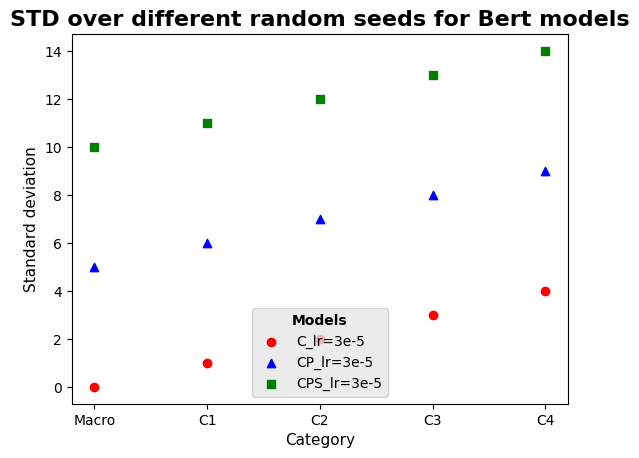

In [21]:
### Plot: variance over random seeds for Bert Models
# 1 grafico per lr (eventualmente mergiare 2 grafici)
# 5 colonne (macro + per cat)
# punti = std dev (C, CP, CPS)

### allungabile con altre versioni (learning rate o 2 epoch)
std_devs = (
    std_f1_c_lr3,
    std_f1_cp_lr3,
    std_f1_cps_lr3,
)
color_list = ["red", "blue", "green"]
marker_list = ["o", "^", "s"]
label_list = [
    "C_lr=3e-5",
    "CP_lr=3e-5",
    "CPS_lr=3e-5",
]

x_labels = ["Macro", "C1", "C2", "C3", "C4"]
plt.title("STD over different random seeds for Bert models", fontdict=title_font)
plt.xlabel("Category", fontdict=axis_font)
plt.ylabel("Standard deviation", fontdict=axis_font)
plt.xticks(ticks=range(len(std_devs[0])), labels=x_labels)
# plt.yscale("log")

for s, color, label, marker in zip(std_devs, color_list, label_list, marker_list):
    plt.scatter(x=range(len(s)), y=s, c=color, label=label, marker=marker)
plt.legend(
    title="Models",
    facecolor=(0.9, 0.9, 0.9),
    title_fontproperties=legend_title_font,
    # ncols=3,
    loc="lower center",
)

### STD Versione corta con lr2

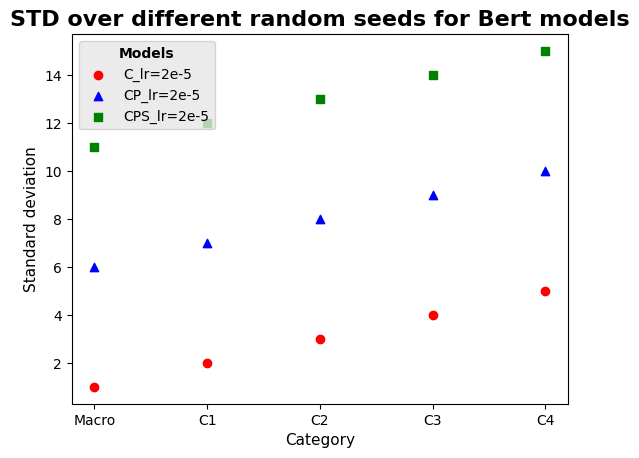

In [22]:
### Plot: variance over random seeds for Bert Models
# 1 grafico per lr (eventualmente mergiare 2 grafici)
# 5 colonne (macro + per cat)
# punti = std dev (C, CP, CPS)

### allungabile con altre versioni (learning rate o 2 epoch)
std_devs = (
    std_f1_c_lr2,
    std_f1_cp_lr2,
    std_f1_cps_lr2,
)
color_list = ["red", "blue", "green"]
marker_list = ["o", "^", "s"]
label_list = [
    "C_lr=2e-5",
    "CP_lr=2e-5",
    "CPS_lr=2e-5",
]

x_labels = ["Macro", "C1", "C2", "C3", "C4"]
plt.title("STD over different random seeds for Bert models", fontdict=title_font)
plt.xlabel("Category", fontdict=axis_font)
plt.ylabel("Standard deviation", fontdict=axis_font)
plt.xticks(ticks=range(len(std_devs[0])), labels=x_labels)
# plt.yscale("log")

for s, color, label, marker in zip(std_devs, color_list, label_list, marker_list):
    plt.scatter(x=range(len(s)), y=s, c=color, label=label, marker=marker)
plt.legend(
    title="Models",
    facecolor=(0.9, 0.9, 0.9),
    title_fontproperties=legend_title_font,
    # ncols=3,
)

### f1_score: baseline e lr=3

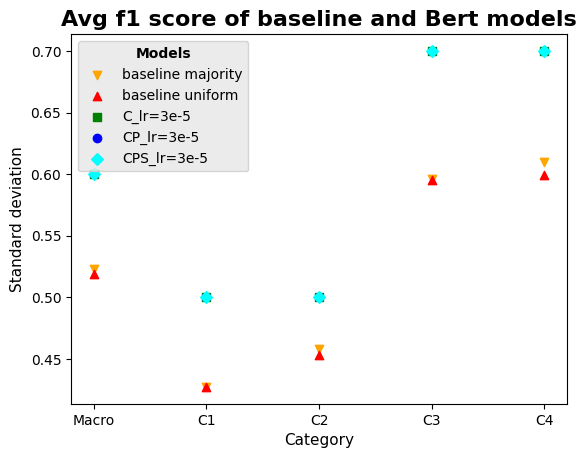

In [33]:
### Plot: f1 score bert vs baseline: overall
# Y: avg f1 score
# X: macro + categories (5)
# series: models: baseline, (c cp, cps)*2 lr *2epoch


f1s = (avg_f1_majority, avg_f1_uniform, avg_f1_c_lr3, avg_f1_cp_lr3, avg_f1_cps_lr3)
color_list = ["orange", "red", "green", "blue", "aqua"]
marker_list = ["v", "^", "s", "o", "D"]
label_list = [
    "baseline majority",
    "baseline uniform",
    "C_lr=3e-5",
    "CP_lr=3e-5",
    "CPS_lr=3e-5",
]

x_labels = ["Macro", "C1", "C2", "C3", "C4"]
plt.title("Avg f1 score of baseline and Bert models", fontdict=title_font)
plt.xlabel("Category", fontdict=axis_font)
plt.ylabel("Standard deviation", fontdict=axis_font)
plt.xticks(ticks=range(len(std_devs[0])), labels=x_labels)
# plt.yscale("log")

for s, color, label, marker in zip(f1s, color_list, label_list, marker_list):
    plt.scatter(x=range(len(s)), y=s, c=color, label=label, marker=marker)
plt.legend(
    title="Models",
    facecolor=(0.9, 0.9, 0.9),
    title_fontproperties=legend_title_font,
    # ncols=3,
)

### f1_score: baseline e lr=2

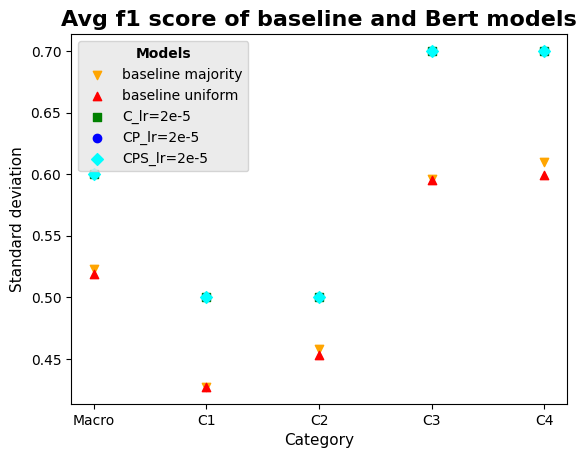

In [34]:
### Plot: f1 score bert vs baseline: overall
# Y: avg f1 score
# X: macro + categories (5)
# series: models: baseline, (c cp, cps)*2 lr *2epoch


f1s = (avg_f1_majority, avg_f1_uniform, avg_f1_c_lr2, avg_f1_cp_lr2, avg_f1_cps_lr2)
color_list = ["orange", "red", "green", "blue", "aqua"]
marker_list = ["v", "^", "s", "o", "D"]
label_list = [
    "baseline majority",
    "baseline uniform",
    "C_lr=2e-5",
    "CP_lr=2e-5",
    "CPS_lr=2e-5",
]

x_labels = ["Macro", "C1", "C2", "C3", "C4"]
plt.title("Avg f1 score of baseline and Bert models", fontdict=title_font)
plt.xlabel("Category", fontdict=axis_font)
plt.ylabel("Standard deviation", fontdict=axis_font)
plt.xticks(ticks=range(len(std_devs[0])), labels=x_labels)
# plt.yscale("log")

for s, color, label, marker in zip(f1s, color_list, label_list, marker_list):
    plt.scatter(x=range(len(s)), y=s, c=color, label=label, marker=marker)
plt.legend(
    title="Models",
    facecolor=(0.9, 0.9, 0.9),
    title_fontproperties=legend_title_font,
    # ncols=3,
)

### f1 score: versione lunga: baseline + lr2 + lr3

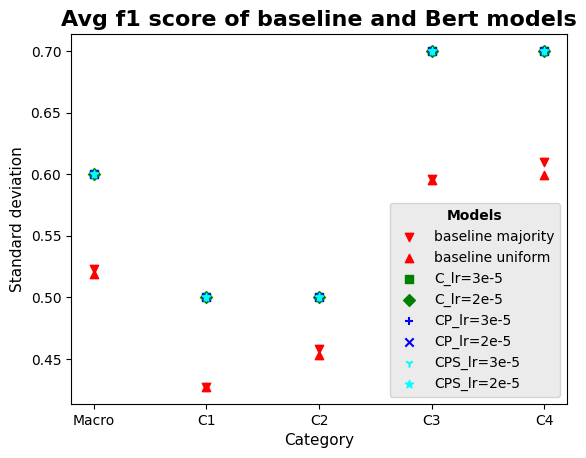

In [35]:
### Plot: f1 score bert vs baseline: overall
# Y: avg f1 score
# X: macro + categories (5)
# series: models: baseline, (c cp, cps)*2 lr *2epoch


f1s = (
    avg_f1_majority,
    avg_f1_uniform,
    avg_f1_c_lr3,
    avg_f1_c_lr2,
    avg_f1_cp_lr3,
    avg_f1_cp_lr2,
    avg_f1_cps_lr3,
    avg_f1_cps_lr2,
)
color_list = ["red", "red", "green", "green", "blue", "blue", "aqua", "aqua"]
marker_list = ["v", "^", "s", "D", "+", "x", "1", "*"]
label_list = [
    "baseline majority",
    "baseline uniform",
    "C_lr=3e-5",
    "C_lr=2e-5",
    "CP_lr=3e-5",
    "CP_lr=2e-5",
    "CPS_lr=3e-5",
    "CPS_lr=2e-5",
]

x_labels = ["Macro", "C1", "C2", "C3", "C4"]
plt.title("Avg f1 score of baseline and Bert models", fontdict=title_font)
plt.xlabel("Category", fontdict=axis_font)
plt.ylabel("Standard deviation", fontdict=axis_font)
plt.xticks(ticks=range(len(std_devs[0])), labels=x_labels)
# plt.yscale("log")

for s, color, label, marker in zip(f1s, color_list, label_list, marker_list):
    plt.scatter(x=range(len(s)), y=s, c=color, label=label, marker=marker)
plt.legend(
    title="Models",
    facecolor=(0.9, 0.9, 0.9),
    title_fontproperties=legend_title_font,
    # ncols=3,
)

### f1 score e class frequency, baseline e lr3

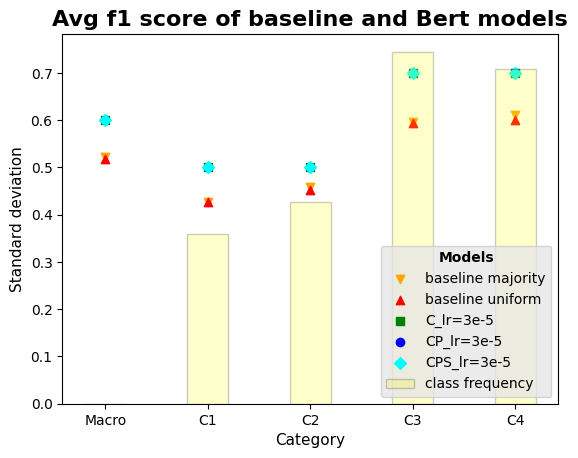

In [36]:
### Plot: class frequency(column) vs f1 score per model (scatter)
# Y: avg f1 score
# X: macro + categories (5)
# series: models: baseline, (c cp, cps), columns: class frequency


f1s = (avg_f1_majority, avg_f1_uniform, avg_f1_c_lr3, avg_f1_cp_lr3, avg_f1_cps_lr3)
color_list = ["orange", "red", "green", "blue", "aqua"]
marker_list = ["v", "^", "s", "o", "D"]
label_list = [
    "baseline majority",
    "baseline uniform",
    "C_lr=3e-5",
    "CP_lr=3e-5",
    "CPS_lr=3e-5",
]

x_labels = ["Macro", "C1", "C2", "C3", "C4"]
plt.title("Avg f1 score of baseline and Bert models", fontdict=title_font)
plt.xlabel("Category", fontdict=axis_font)
plt.ylabel("Standard deviation", fontdict=axis_font)
plt.xticks(ticks=range(len(std_devs[0])), labels=x_labels)
# plt.yscale("log")

for s, color, label, marker in zip(f1s, color_list, label_list, marker_list):
    plt.scatter(x=range(len(s)), y=s, c=color, label=label, marker=marker)

### TODO plot hist with class freq
plt.bar(
    x=np.arange(len(class_frequencies)),
    height=(class_frequencies),
    width=0.4,
    color=(1, 1, 0),
    edgecolor="black",
    label="class frequency",
    alpha=0.2,
)


plt.legend(
    title="Models",
    facecolor=(0.9, 0.9, 0.9),
    title_fontproperties=legend_title_font,
    loc="lower right"
    # ncols=3,
    # draggable=True, ### does not work on vscode
)